In [ ]:
import torch
torch.__version__

In [ ]:
import torchaudio
torchaudio.__version__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install stable-baselines3[extra]

In [ ]:
!pip install numpngw
!pip install omegaconf
!pip install envpool

In [ ]:
from dataclasses import dataclass


In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ppo/#ppo_atari_envpoolpy
import os
import random
import time
from collections import deque
from dataclasses import dataclass
import math
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStack
from torch.autograd import Variable

import envpool
import gym

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

## PPO

In [ ]:
@dataclass
class Args:
    exp_name: str = "iqn_ppo_run1"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "SpaceInvaders-v5"
    """the id of the environment"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""

## Utils

In [ ]:
class RecordEpisodeStatistics(gym.Wrapper):
    def __init__(self, env, deque_size=100):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.episode_returns = None
        self.episode_lengths = None

    def reset(self, **kwargs):
        observations = super().reset(**kwargs)
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        self.lives = np.zeros(self.num_envs, dtype=np.int32)
        self.returned_episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.returned_episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return observations

    def step(self, action):
        observations, rewards, dones, infos = super().step(action)
        self.episode_returns += infos["reward"]
        self.episode_lengths += 1
        self.returned_episode_returns[:] = self.episode_returns
        self.returned_episode_lengths[:] = self.episode_lengths
        self.episode_returns *= 1 - infos["terminated"]
        self.episode_lengths *= 1 - infos["terminated"]
        infos["r"] = self.returned_episode_returns
        infos["l"] = self.returned_episode_lengths
        return (
            observations,
            rewards,
            dones,
            infos,
        )


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

## Agent Networks

### PPO Agent

In [ ]:
class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

### Replace Value with Q

In [ ]:
class ReplaceValueQuantileAgent(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        #critic_out = self.critic(state_embeddings)

        #value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1))
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), q.mean(dim=-1, keepdim=True)

### Simple Embed

In [ ]:
class SimpleEmbedAgent(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape} and q shape: {q.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)
        quantile_mean = torch.mean(q, dim=1).unsqueeze(-1)
        #print(f"critic_out shape: {critic_out.shape} and q shape: {quantile_mean.shape}")
        simple_embed = (critic_out + quantile_mean)/2
        #print(f"simple embed shape: {simple_embed.shape}")
        #raise ValueError("Training Stopped")

        #value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1))
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), simple_embed

### Attention

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        #print(f"pe shape: {pe.shape}")
        position = torch.arange(0, max_len).unsqueeze(1)
        #print(f"position shape: {position.shape}")
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        #print(f"div_term shape: {div_term.shape}")
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #print(f"pe shape: {pe.shape}")
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x.unsqueeze(-1)
        #print(f"x shape: {x.shape}")
        pos = Variable(self.pe[:, :x.size(-2)], requires_grad=False)
        #print(f"pos shape: {pos.shape}")
        x = x + pos
        return self.dropout(x)

In [ ]:
class AttentionQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.cat_size = action_dim + 1
    self.network = nn.Sequential(
        nn.Linear(512, 512//2),
        nn.ReLU(),
        nn.Linear(512//2, 1),
        nn.ReLU()
    )
    self.positional_encoding = PositionalEncoding(d_model=512, dropout=0.1)
    self.encoder = encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    scaled_quantiles = quantiles * scale

    cat = torch.cat((embeddings, scaled_quantiles), dim=-1)
    pos_cat = self.positional_encoding(cat)
    encoder_out = self.transformer_encoder(pos_cat)

    out = self.network(encoder_out)
    #print(f"out shaep: {out.shape}")
    #raise ValueError("Stopped")

    return out.mean(dim=1, keepdim=True)

In [ ]:
class AttentionAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = AttentionQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### Concat

In [ ]:
class ConcatQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.cat_size = action_dim + 1
    self.network = nn.Sequential(
        nn.Linear(self.cat_size, self.cat_size*2),
        nn.ReLU(),
        nn.Linear(self.cat_size*2, self.cat_size),
        nn.ReLU()
    )

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    scaled_quantiles = quantiles * scale

    out = (embeddings * scaled_quantiles)
    cat = torch.cat((embeddings, scaled_quantiles), dim=-1)
    #print(f"cat shape: {cat.shape}")


    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    out = self.network(cat)
    #print(f"out shaep: {out.shape}")
    #raise ValueError("Stopped")

    return out.mean(dim=1, keepdim=True)

In [ ]:
class ConcatAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = ConcatQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### Bilinear Weights

In [ ]:
class BilinearQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(1, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, 1),
        nn.ReLU()
    )
    self.bilinear = nn.Bilinear(6,1,1)

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    out = self.bilinear(quantiles, embeddings)
    #print(f"out shape: {out.shape}")
    #raise ValueError("Stopped")

    #out = self.network(out)
    #print(f"out shape: {out.shape}")
    #raise ValueError("Stopped")

    return out

In [ ]:
class BilinearAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = BilinearQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### Learnable Weights

In [ ]:
class LearnableWeightsQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(1, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, 1),
        nn.ReLU()
    )
    self.weights = torch.nn.Parameter(torch.rand(6))
    self.bias = torch.nn.Parameter(torch.rand(1))

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    scaled_quantiles = torch.mean(quantiles * self.weights, dim=-1).unsqueeze(-1)
    #print(f"scaled_quantiles: {scaled_quantiles.shape}")

    scaled_embeddings = self.bias * embeddings
    #print(f"scaled_embeddings: {scaled_embeddings.shape}")

    out = scaled_embeddings + scaled_quantiles
    #print(f"out shape: {out.shape}")
    #raise ValueError("Stopped")

    out = self.network(out)
    #print(f"out shape: {out.shape}")
    #raise ValueError("Stopped")

    return out

In [ ]:
class LearnableWeightsAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = LearnableWeightsQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### ScaledQDistillation


In [ ]:
class ScaledQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, action_dim),
        nn.ReLU()
    )
    self.scale = nn.Parameter(torch.rand(1))

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    scaled_quantiles = quantiles * self.scale
    #print(f"scaled_quantiles: {scaled_quantiles.shape}")
    out = (embeddings * scaled_quantiles)
    #print(f"out: {out.shape}")

    out = self.network(out)

    return out.mean(dim=1, keepdim=True)

In [ ]:
class ScaledAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = ScaledQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### QDistillation (Best Results)

In [ ]:
class QDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, action_dim),
        nn.ReLU()
    )

  def forward(self, embeddings, quantiles, scale=1.0):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    scaled_quantiles = quantiles * scale

    out = (embeddings * scaled_quantiles)
    out = out.squeeze(-1)

    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    out = self.network(out)

    return out.mean(dim=1, keepdim=True)

In [ ]:
class AgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1))
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### TD Method

In [ ]:
class TDDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ELU()
    )

  def forward(self, embeddings, quantiles, action_probs):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    # print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0], embeddings.shape
    assert quantiles.shape == action_probs.shape, f"quantiles: {quantiles.shape}, action: {action_probs.shape}"

    out = embeddings + self.network((action_probs * quantiles) - embeddings)

    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    # out = self.network(out)

    return out.mean(dim=1, keepdim=True)

In [ ]:
class AgentCriticTDDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = TDDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None):
        # print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out, q, dist.probs)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### SIngleHead Network Distillation

In [ ]:
class SingleHeadQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, 1),
        nn.ReLU()
    )

  def forward(self, embeddings, quantiles):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    out = (embeddings * quantiles)
    out = out.squeeze(-1)

    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    out = self.network(out)

    return out

In [ ]:
class SingleHeadAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def AddNormalize(self, embeddings, distillation_embeddings):
        embeds = embeddings + self.delta * distillation_embeddings
        mean = embeds.mean(dim=-1, keepdim=True)
        std = embeds.std(dim=-1, keepdim=True)
        embeds = (embeds - mean) / (std + 1e-6)
        return embeds

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1))
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### SIngleHead Mean Distillation

In [ ]:
class AvgHeadAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def AddNormalize(self, embeddings, distillation_embeddings):
        embeds = embeddings + self.delta * distillation_embeddings
        mean = embeds.mean(dim=-1, keepdim=True)
        std = embeds.std(dim=-1, keepdim=True)
        embeds = (embeds - mean) / (std + 1e-6)
        return embeds

    def forward(self, x, q, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = (critic_out + q.mean(dim=-1, keepdim=True)) / 2

        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings

### Normalized Distillation

In [ ]:
class NormalizedQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, action_dim),
        nn.ReLU()
    )

  def forward(self, embeddings, quantiles):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    out = (embeddings * quantiles)
    out = out.squeeze(-1)

    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    out = self.network(out)

    return out

In [ ]:
class AgentCriticNormalizedDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, action_dim)
        self.delta = 1.0
        self.distillation_network = NormalizedQDistillationNetwork(action_dim, self.N)

    def AddNormalize(self, embeddings, distillation_embeddings):
        embeds = embeddings + self.delta * distillation_embeddings
        mean = embeds.mean(dim=-1, keepdim=True)

        std = embeds.std(dim=-1, keepdim=True)

        embeds = (embeds - mean) / (std + 1e-6)
        return embeds

    def forward(self, x, q, start_iqn=False, action=None):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        #print(state_embeddings.shape)
        action_embeddings = self.actor(state_embeddings)
        #print(action_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1))

        value_embeddings = self.AddNormalize(critic_out, value_embeddings)

        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings.mean(dim=-1, keepdim=True)

In [ ]:
"""class AgentCriticLagDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, action_dim)
        self.delta = 0.5
        self.distillation_network = QDistillationNetwork(action_dim, self.N)

    def AddNormalize(self, action_embeddings, distillation_embeddings):
        embeds = action_embeddings + self.delta * distillation_embeddings
        mean = embeds.mean(dim=-1, keepdim=True)
        std = embeds.std(dim=-1, keepdim=True)
        embeds = (embeds - mean) / (std + 1e-6)
        return embeds

    def forward(self, x, q, start_iqn=False, action=None):
        #print(f"x shape: {q.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        value_embeddings = self.distillation_network(self.critic(state_embeddings), q).mean(dim=1, keepdim=True) if start_iqn else self.crtic(state_embeddings).mean(dim=1, keepdim=True)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value_embeddings"""

### Lag Distillation

In [ ]:
class LagQDistillationNetwork(nn.Module):
  def __init__(self, action_dim, N):
    super().__init__()
    self.action_dim = action_dim
    self.network = nn.Sequential(
        nn.Linear(action_dim, action_dim),
        nn.ReLU(),
        nn.Linear(action_dim, action_dim),
        nn.ReLU()
    )

  def forward(self, embeddings, quantiles, start_iqn):
    # q shape: [batch_size, action_dim]
    # embeddings shape: [batch_size, action_dim]
    batch_size = embeddings.shape[0]
    #print(f"_embed: {embeddings.shape} and quantile: {quantiles.shape}")
    assert embeddings.shape[0] == quantiles.shape[0]

    out = (embeddings * quantiles)
    out = out.squeeze(-1)

    assert out.shape == (batch_size, self.action_dim), f"out shape: {out.shape}"
    out = self.network(out)

    return out.mean(dim=1, keepdim=True) if start_iqn else embeddings.squeeze(-1)

In [ ]:
class LagAgentCriticDistillation(nn.Module):
    def __init__(self, action_dim, N):
        super().__init__()

        self.num_actions = action_dim
        self.N = N

        self.network = nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7,512),
            nn.ReLU(),
        )

        self.actor = nn.Linear(512, action_dim)
        self.critic = nn.Linear(512, 1)
        self.delta = 1.0
        self.distillation_network = LagQDistillationNetwork(action_dim, self.N)

    def forward(self, x, q, action=None, start_iqn=False):
        #print(f"x shape: {x.shape}")
        state_embeddings = self.network(x / 255.0) # [batch_size, 512]

        action_embeddings = self.actor(state_embeddings)
        dist = Categorical(logits=action_embeddings)

        critic_out = self.critic(state_embeddings)

        value_embeddings = self.distillation_network(critic_out.unsqueeze(-1), q.unsqueeze(-1), start_iqn)
        if action is None:
            action = dist.sample()

        return action, dist.log_prob(action), dist.entropy(), value_embeddings

## IQN
[Code Link](https://github.com/toshikwa/fqf-iqn-qrdqn.pytorch)

### IQN Utils

In [ ]:
def update_params(optim, loss, networks, retain_graph=False,
                  grad_cliping=None):
    optim.zero_grad()
    loss.backward(retain_graph=retain_graph)
    # Clip norms of gradients to stebilize training.
    if grad_cliping:
        for net in networks:
            torch.nn.utils.clip_grad_norm_(net.parameters(), grad_cliping)
    optim.step()


def disable_gradients(network):
    # Disable calculations of gradients.
    for param in network.parameters():
        param.requires_grad = False


def calculate_huber_loss(td_errors, kappa=1.0):
    return torch.where(
        td_errors.abs() <= kappa,
        0.5 * td_errors.pow(2),
        kappa * (td_errors.abs() - 0.5 * kappa))


def calculate_quantile_huber_loss(td_errors, taus, weights=None, kappa=1.0):
    assert not taus.requires_grad
    batch_size, N, N_dash = td_errors.shape

    # Calculate huber loss element-wisely.
    element_wise_huber_loss = calculate_huber_loss(td_errors, kappa)
    assert element_wise_huber_loss.shape == (
        batch_size, N, N_dash)

    # Calculate quantile huber loss element-wisely.
    element_wise_quantile_huber_loss = torch.abs(
        taus[..., None] - (td_errors.detach() < 0).float()
        ) * element_wise_huber_loss / kappa
    assert element_wise_quantile_huber_loss.shape == (
        batch_size, N, N_dash)

    # Quantile huber loss.
    batch_quantile_huber_loss = element_wise_quantile_huber_loss.sum(
        dim=1).mean(dim=1, keepdim=True)
    assert batch_quantile_huber_loss.shape == (batch_size, 1)

    if weights is not None:
        quantile_huber_loss = (batch_quantile_huber_loss * weights).mean()
    else:
        quantile_huber_loss = batch_quantile_huber_loss.mean()

    return quantile_huber_loss


def evaluate_quantile_at_action(s_quantiles, actions):
    assert s_quantiles.shape[0] == actions.shape[0]

    batch_size = s_quantiles.shape[0]
    N = s_quantiles.shape[1]

    # Expand actions into (batch_size, N, 1).
    action_index = actions[..., None].expand(batch_size, N, 1)

    # Calculate quantile values at specified actions.
    sa_quantiles = s_quantiles.gather(dim=2, index=action_index)

    return sa_quantiles


class RunningMeanStats:

    def __init__(self, n=10):
        self.n = n
        self.stats = deque(maxlen=n)

    def append(self, x):
        self.stats.append(x)

    def get(self):
        return np.mean(self.stats)


class LinearAnneaer:

    def __init__(self, start_value, end_value, num_steps):
        assert num_steps > 0 and isinstance(num_steps, int)

        self.steps = 0
        self.start_value = start_value
        self.end_value = end_value
        self.num_steps = num_steps

        self.a = (self.end_value - self.start_value) / self.num_steps
        self.b = self.start_value

    def step(self):
        self.steps = min(self.num_steps, self.steps + 1)

    def get(self):
        assert 0 < self.steps <= self.num_steps
        return self.a * self.steps + self.b


### Networks

In [ ]:
from copy import copy
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


def initialize_weights_xavier(m, gain=1.0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=gain)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


def initialize_weights_he(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class DQNBase(nn.Module):

    def __init__(self, num_channels, embedding_dim=7*7*64):
        super(DQNBase, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            Flatten(),
        ).apply(initialize_weights_he)

        self.embedding_dim = embedding_dim

    def forward(self, states):
        batch_size = states.shape[0]

        # Calculate embeddings of states.
        state_embedding = self.net(states)
        assert state_embedding.shape == (batch_size, self.embedding_dim)

        return state_embedding


class FractionProposalNetwork(nn.Module):

    def __init__(self, N=32, embedding_dim=7*7*64):
        super(FractionProposalNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(embedding_dim, N)
        ).apply(lambda x: initialize_weights_xavier(x, gain=0.01))

        self.N = N
        self.embedding_dim = embedding_dim

    def forward(self, state_embeddings):

        batch_size = state_embeddings.shape[0]

        # Calculate (log of) probabilities q_i in the paper.
        log_probs = F.log_softmax(self.net(state_embeddings), dim=1)
        probs = log_probs.exp()
        assert probs.shape == (batch_size, self.N)

        tau_0 = torch.zeros(
            (batch_size, 1), dtype=state_embeddings.dtype,
            device=state_embeddings.device)
        taus_1_N = torch.cumsum(probs, dim=1)

        # Calculate \tau_i (i=0,...,N).
        taus = torch.cat((tau_0, taus_1_N), dim=1)
        assert taus.shape == (batch_size, self.N+1)

        # Calculate \hat \tau_i (i=0,...,N-1).
        tau_hats = (taus[:, :-1] + taus[:, 1:]).detach() / 2.
        assert tau_hats.shape == (batch_size, self.N)

        # Calculate entropies of value distributions.
        entropies = -(log_probs * probs).sum(dim=-1, keepdim=True)
        assert entropies.shape == (batch_size, 1)

        return taus, tau_hats, entropies


class CosineEmbeddingNetwork(nn.Module):

    def __init__(self, num_cosines=64, embedding_dim=7*7*64, noisy_net=False):
        super(CosineEmbeddingNetwork, self).__init__()
        linear = NoisyLinear if noisy_net else nn.Linear

        self.net = nn.Sequential(
            linear(num_cosines, embedding_dim),
            nn.ReLU()
        )
        self.num_cosines = num_cosines
        self.embedding_dim = embedding_dim

    def forward(self, taus):
        batch_size = taus.shape[0]
        N = taus.shape[1]

        # Calculate i * \pi (i=1,...,N).
        i_pi = np.pi * torch.arange(
            start=1, end=self.num_cosines+1, dtype=taus.dtype,
            device=taus.device).view(1, 1, self.num_cosines)

        # Calculate cos(i * \pi * \tau).
        cosines = torch.cos(
            taus.view(batch_size, N, 1) * i_pi
            ).view(batch_size * N, self.num_cosines)

        # Calculate embeddings of taus.
        tau_embeddings = self.net(cosines).view(
            batch_size, N, self.embedding_dim)

        return tau_embeddings


class QuantileNetwork(nn.Module):

    def __init__(self, num_actions, embedding_dim=7*7*64, dueling_net=False,
                 noisy_net=False):
        super(QuantileNetwork, self).__init__()
        linear = NoisyLinear if noisy_net else nn.Linear

        if not dueling_net:
            self.net = nn.Sequential(
                linear(embedding_dim, 512),
                nn.ReLU(),
                linear(512, num_actions),
            )
        else:
            self.advantage_net = nn.Sequential(
                linear(embedding_dim, 512),
                nn.ReLU(),
                linear(512, num_actions),
            )
            self.baseline_net = nn.Sequential(
                linear(embedding_dim, 512),
                nn.ReLU(),
                linear(512, 1),
            )

        self.num_actions = num_actions
        self.embedding_dim = embedding_dim
        self.dueling_net = dueling_net
        self.noisy_net = noisy_net

    def forward(self, state_embeddings, tau_embeddings):
        assert state_embeddings.shape[0] == tau_embeddings.shape[0]
        assert state_embeddings.shape[1] == tau_embeddings.shape[2]

        # NOTE: Because variable taus correspond to either \tau or \hat \tau
        # in the paper, N isn't neccesarily the same as fqf.N.
        batch_size = state_embeddings.shape[0]
        N = tau_embeddings.shape[1]

        # Reshape into (batch_size, 1, embedding_dim).
        state_embeddings = state_embeddings.view(
            batch_size, 1, self.embedding_dim)

        # Calculate embeddings of states and taus.
        embeddings = (state_embeddings * tau_embeddings).view(
            batch_size * N, self.embedding_dim)

        # Calculate quantile values.
        if not self.dueling_net:
            quantiles = self.net(embeddings)
        else:
            advantages = self.advantage_net(embeddings)
            baselines = self.baseline_net(embeddings)
            quantiles =\
                baselines + advantages - advantages.mean(1, keepdim=True)

        return quantiles.view(batch_size, N, self.num_actions)


class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma=0.5):
        super(NoisyLinear, self).__init__()

        # Learnable parameters.
        self.mu_W = nn.Parameter(
            torch.FloatTensor(out_features, in_features))
        self.sigma_W = nn.Parameter(
            torch.FloatTensor(out_features, in_features))
        self.mu_bias = nn.Parameter(torch.FloatTensor(out_features))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(out_features))

        # Factorized noise parameters.
        self.register_buffer('eps_p', torch.FloatTensor(in_features))
        self.register_buffer('eps_q', torch.FloatTensor(out_features))

        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma

        self.reset()
        self.sample()

    def reset(self):
        bound = 1 / np.sqrt(self.in_features)
        self.mu_W.data.uniform_(-bound, bound)
        self.mu_bias.data.uniform_(-bound, bound)
        self.sigma_W.data.fill_(self.sigma / np.sqrt(self.in_features))
        self.sigma_bias.data.fill_(self.sigma / np.sqrt(self.out_features))

    def f(self, x):
        return x.normal_().sign().mul(x.abs().sqrt())

    def sample(self):
        self.eps_p.copy_(self.f(self.eps_p))
        self.eps_q.copy_(self.f(self.eps_q))

    def forward(self, x):
        if self.training:
            weight = self.mu_W + self.sigma_W * self.eps_q.ger(self.eps_p)
            bias = self.mu_bias + self.sigma_bias * self.eps_q.clone()
        else:
            weight = self.mu_W
            bias = self.mu_bias

        return F.linear(x, weight, bias)

### IQN Memory

In [ ]:
from collections import deque
import numpy as np
import torch


class MultiStepBuff:

    def __init__(self, maxlen=3):
        super(MultiStepBuff, self).__init__()
        self.maxlen = int(maxlen)
        self.reset()

    def append(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def get(self, gamma=0.99):
        assert len(self.rewards) > 0
        state = self.states.popleft()
        action = self.actions.popleft()
        reward = self._nstep_return(gamma)
        return state, action, reward

    def _nstep_return(self, gamma):
        r = np.sum([r * (gamma ** i) for i, r in enumerate(self.rewards)])
        self.rewards.popleft()
        return r

    def reset(self):
        # Buffer to store n-step transitions.
        self.states = deque(maxlen=self.maxlen)
        self.actions = deque(maxlen=self.maxlen)
        self.rewards = deque(maxlen=self.maxlen)

    def is_empty(self):
        return len(self.rewards) == 0

    def is_full(self):
        return len(self.rewards) == self.maxlen

    def __len__(self):
        return len(self.rewards)


class LazyMemory(dict):
    state_keys = ['state', 'next_state']
    np_keys = ['action', 'reward', 'done']
    keys = state_keys + np_keys

    def __init__(self, capacity, state_shape, device):
        super(LazyMemory, self).__init__()
        self.capacity = int(capacity)
        self.state_shape = state_shape
        self.device = device
        self.reset()

    def reset(self):
        self['state'] = []
        self['next_state'] = []

        self['action'] = np.empty((self.capacity, 1), dtype=np.int64)
        self['reward'] = np.empty((self.capacity, 1), dtype=np.float32)
        self['done'] = np.empty((self.capacity, 1), dtype=np.float32)

        self._n = 0
        self._p = 0

    def append(self, state, action, reward, next_state, done,
               episode_done=None):
        self._append(state, action, reward, next_state, done)

    def _append(self, state, action, reward, next_state, done):
        self['state'].append(state)
        self['next_state'].append(next_state)
        self['action'][self._p] = action
        self['reward'][self._p] = reward
        self['done'][self._p] = done

        self._n = min(self._n + 1, self.capacity)
        self._p = (self._p + 1) % self.capacity

        self.truncate()

    def truncate(self):
        while len(self) > self.capacity:
            del self['state'][0]
            del self['next_state'][0]

    def sample(self, batch_size):
        indices = np.random.randint(low=0, high=len(self), size=batch_size)
        return self._sample(indices, batch_size)

    def _sample(self, indices, batch_size):
        bias = -self._p if self._n == self.capacity else 0

        states = np.empty(
            (batch_size, *self.state_shape), dtype=np.uint8)
        next_states = np.empty(
            (batch_size, *self.state_shape), dtype=np.uint8)

        for i, index in enumerate(indices):
            _index = np.mod(index+bias, self.capacity)
            states[i, ...] = self['state'][_index]
            next_states[i, ...] = self['next_state'][_index]

        states = torch.ByteTensor(states).to(self.device).float() / 255.
        next_states = torch.ByteTensor(
            next_states).to(self.device).float() / 255.
        actions = torch.LongTensor(self['action'][indices]).to(self.device)
        rewards = torch.FloatTensor(self['reward'][indices]).to(self.device)
        dones = torch.FloatTensor(self['done'][indices]).to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self['state'])

    def get(self):
        return dict(self)

    def load(self, memory):
        for key in self.state_keys:
            self[key].extend(memory[key])

        num_data = len(memory['state'])
        if self._p + num_data <= self.capacity:
            for key in self.np_keys:
                self[key][self._p:self._p+num_data] = memory[key]
        else:
            mid_index = self.capacity - self._p
            end_index = num_data - mid_index
            for key in self.np_keys:
                self[key][self._p:] = memory[key][:mid_index]
                self[key][:end_index] = memory[key][mid_index:]

        self._n = min(self._n + num_data, self.capacity)
        self._p = (self._p + num_data) % self.capacity
        self.truncate()
        assert self._n == len(self)


class LazyMultiStepMemory(LazyMemory):

    def __init__(self, capacity, state_shape, device, gamma=0.99,
                 multi_step=3):
        super(LazyMultiStepMemory, self).__init__(
            capacity, state_shape, device)

        self.gamma = gamma
        self.multi_step = int(multi_step)
        if self.multi_step != 1:
            self.buff = MultiStepBuff(maxlen=self.multi_step)

    def append(self, state, action, reward, next_state, done):
        if self.multi_step != 1:
            self.buff.append(state, action, reward)

            if self.buff.is_full():
                state, action, reward = self.buff.get(self.gamma)
                self._append(state, action, reward, next_state, done)

            if done:
                while not self.buff.is_empty():
                    state, action, reward = self.buff.get(self.gamma)
                    self._append(state, action, reward, next_state, done)
        else:
            self._append(state, action, reward, next_state, done)


In [ ]:
import operator


class SegmentTree:

    def __init__(self, size, op, init_val):
        assert size > 0 and size & (size - 1) == 0
        self._size = size
        self._op = op
        self._init_val = init_val
        self._values = [init_val for _ in range(2 * size)]

    def _reduce(self, start=0, end=None):
        if end is None:
            end = self._size
        elif end < 0:
            end += self._size

        start += self._size
        end += self._size

        res = self._init_val
        while start < end:
            if start & 1:
                res = self._op(res, self._values[start])
                start += 1

            if end & 1:
                end -= 1
                res = self._op(res, self._values[end])

            start //= 2
            end //= 2

        return res

    def __setitem__(self, idx, val):
        assert 0 <= idx < self._size

        # Set value.
        idx += self._size
        self._values[idx] = val

        # Update its ancestors iteratively.
        idx = idx >> 1
        while idx >= 1:
            left = 2 * idx
            self._values[idx] = \
                self._op(self._values[left], self._values[left + 1])
            idx = idx >> 1

    def __getitem__(self, idx):
        assert 0 <= idx < self._size
        return self._values[idx + self._size]


class SumTree(SegmentTree):

    def __init__(self, size):
        super().__init__(size, operator.add, 0.0)

    def sum(self, start=0, end=None):
        return self._reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1

        # Traverse to the leaf.
        while idx < self._size:
            left = 2 * idx
            if self._values[left] > prefixsum:
                idx = left
            else:
                prefixsum -= self._values[left]
                idx = left + 1
        return idx - self._size


class MinTree(SegmentTree):

    def __init__(self, size):
        super().__init__(size, min, float("inf"))

    def min(self, start=0, end=None):
        return self._reduce(start, end)


In [ ]:
import numpy as np
import torch


class LazyPrioritizedMultiStepMemory(LazyMultiStepMemory):

    def __init__(self, capacity, state_shape, device, gamma=0.99,
                 multi_step=3, alpha=0.5, beta=0.4, beta_steps=2e5,
                 min_pa=0.0, max_pa=1.0, eps=0.01):
        super().__init__(capacity, state_shape, device, gamma, multi_step)

        self.alpha = alpha
        self.beta = beta
        self.beta_diff = (1.0 - beta) / beta_steps
        self.min_pa = min_pa
        self.max_pa = max_pa
        self.eps = eps
        self._cached = None

        it_capacity = 1
        while it_capacity < capacity:
            it_capacity *= 2
        self.it_sum = SumTree(it_capacity)
        self.it_min = MinTree(it_capacity)

    def _pa(self, p):
        return np.clip((p + self.eps) ** self.alpha, self.min_pa, self.max_pa)

    def append(self, state, action, reward, next_state, done, p=None):
        # Calculate priority.
        if p is None:
            pa = self.max_pa
        else:
            pa = self._pa(p)

        if self.multi_step != 1:
            self.buff.append(state, action, reward)

            if self.buff.is_full():
                state, action, reward = self.buff.get(self.gamma)
                self._append(state, action, reward, next_state, done, pa)

            if done:
                while not self.buff.is_empty():
                    state, action, reward = self.buff.get(self.gamma)
                    self._append(state, action, reward, next_state, done, pa)
        else:
            self._append(state, action, reward, next_state, done, pa)

    def _append(self, state, action, reward, next_state, done, pa):
        # Store priority, which is done efficiently by SegmentTree.
        self.it_min[self._p] = pa
        self.it_sum[self._p] = pa
        super()._append(state, action, reward, next_state, done)

    def _sample_idxes(self, batch_size):
        total_pa = self.it_sum.sum(0, self._n)
        rands = np.random.rand(batch_size) * total_pa
        indices = [self.it_sum.find_prefixsum_idx(r) for r in rands]
        self.beta = min(1., self.beta + self.beta_diff)
        return indices

    def sample(self, batch_size):
        assert self._cached is None, 'Update priorities before sampling.'

        self._cached = self._sample_idxes(batch_size)
        batch = self._sample(self._cached, batch_size)
        weights = self._calc_weights(self._cached)
        return batch, weights

    def _calc_weights(self, indices):
        min_pa = self.it_min.min()
        weights = [(self.it_sum[i] / min_pa) ** -self.beta for i in indices]
        return torch.FloatTensor(weights).to(self.device).view(-1, 1)

    def update_priority(self, errors):
        assert self._cached is not None

        ps = errors.detach().cpu().abs().numpy().flatten()
        pas = self._pa(ps)

        for index, pa in zip(self._cached, pas):
            assert 0 <= index < self._n
            assert 0 < pa
            self.it_sum[index] = pa
            self.it_min[index] = pa

        self._cached = None


### IQN Model

In [ ]:
class BaseModel(nn.Module):

    def __init__(self):
        super().__init__()

    def sample_noise(self):
        if self.noisy_net:
            for m in self.modules():
                if isinstance(m, NoisyLinear):
                    m.sample()


In [ ]:
import torch

class IQN(BaseModel):

    def __init__(self, num_channels, num_actions, K=32, num_cosines=32,
                 embedding_dim=7*7*64, dueling_net=False, noisy_net=False):
        super(IQN, self).__init__()

        # Feature extractor of DQN.
        self.dqn_net = DQNBase(num_channels=num_channels)
        # Cosine embedding network.
        self.cosine_net = CosineEmbeddingNetwork(
            num_cosines=num_cosines, embedding_dim=embedding_dim,
            noisy_net=noisy_net)
        # Quantile network.
        self.quantile_net = QuantileNetwork(
            num_actions=num_actions, dueling_net=dueling_net,
            noisy_net=noisy_net)

        self.K = K
        self.num_channels = num_channels
        self.num_actions = num_actions
        self.num_cosines = num_cosines
        self.embedding_dim = embedding_dim
        self.dueling_net = dueling_net
        self.noisy_net = noisy_net

    def calculate_state_embeddings(self, states):
        return self.dqn_net(states)

    def calculate_quantiles(self, taus, states=None, state_embeddings=None):
        assert states is not None or state_embeddings is not None

        if state_embeddings is None:
            state_embeddings = self.dqn_net(states)

        tau_embeddings = self.cosine_net(taus)
        return self.quantile_net(state_embeddings, tau_embeddings)

    def calculate_q(self, states=None, state_embeddings=None):
        assert states is not None or state_embeddings is not None
        batch_size = states.shape[0] if states is not None\
            else state_embeddings.shape[0]

        if state_embeddings is None:
            state_embeddings = self.dqn_net(states)

        # Sample fractions.
        taus = torch.rand(
            batch_size, self.K, dtype=state_embeddings.dtype,
            device=state_embeddings.device)

        # Calculate quantiles.
        quantiles = self.calculate_quantiles(
            taus, state_embeddings=state_embeddings)
        assert quantiles.shape == (batch_size, self.K, self.num_actions)
        #print(f"quantiles shape: {quantiles.shape}")

        # Calculate expectations of value distributions.
        q = quantiles.mean(dim=1)
        assert q.shape == (batch_size, self.num_actions)

        return q, quantiles


### IQN

In [ ]:
from abc import ABC, abstractmethod
import os
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

class BaseAgent(ABC):

    def __init__(self, observation_space, action_space, num_steps=100000,
                 batch_size=32, memory_size=10**6, gamma=0.99, multi_step=1,
                 update_interval=4, target_update_interval=10000,
                 start_steps=50000, epsilon_train=0.01, epsilon_eval=0.001,
                 epsilon_decay_steps=250000, double_q_learning=False,
                 dueling_net=False, noisy_net=False, use_per=False,
                 log_interval=100, eval_interval=250000, num_eval_steps=125000,
                 max_episode_steps=27000, grad_cliping=5.0, cuda=True, seed=0):

        # torch.backends.cudnn.deterministic = True  # It harms a performance.
        # torch.backends.cudnn.benchmark = False  # It harms a performance.

        self.device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

        self.online_net = None
        self.target_net = None

        # Replay memory which is memory-efficient to store stacked frames.
        if use_per:
            beta_steps = (num_steps - start_steps) / update_interval
            self.memory = LazyPrioritizedMultiStepMemory(
                memory_size, observation_space.shape,
                self.device, gamma, multi_step, beta_steps=beta_steps)
        else:
            self.memory = LazyMultiStepMemory(
                memory_size, observation_space.shape,
                self.device, gamma, multi_step)

        self.steps = 0
        self.learning_steps = 0
        self.episodes = 0
        self.best_eval_score = -np.inf
        self.num_actions = action_space.n
        self.num_steps = num_steps
        self.batch_size = batch_size

        self.double_q_learning = double_q_learning
        self.dueling_net = dueling_net
        self.noisy_net = noisy_net
        self.use_per = use_per

        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.num_eval_steps = num_eval_steps
        self.gamma_n = gamma ** multi_step
        self.start_steps = start_steps
        self.epsilon_train = LinearAnneaer(
            1.0, epsilon_train, epsilon_decay_steps)
        self.epsilon_eval = epsilon_eval
        self.update_interval = update_interval
        self.target_update_interval = target_update_interval
        self.max_episode_steps = max_episode_steps
        self.grad_cliping = grad_cliping

        print(f"Agent Initialized: double q learning {self.double_q_learning}")
        print(f"Agent Initialized: dueling net {self.dueling_net}")
        print(f"Agent Initialized: noisy net {self.noisy_net}")
        print(f"Agent Initialized: use per {self.use_per}")

    def is_update(self):
        return self.steps % self.update_interval == 0\
            and self.steps >= self.start_steps

    def is_random(self, eval=False):
        # Use e-greedy for evaluation.
        if self.steps < self.start_steps:
            return True
        if eval:
            return np.random.rand() < self.epsilon_eval
        if self.noisy_net:
            return False
        return np.random.rand() < self.epsilon_train.get()

    def update_target(self):
        self.target_net.load_state_dict(
            self.online_net.state_dict())

    def explore(self):
        # Act with randomness.
        action = self.env.action_space.sample()
        return action

    def exploit(self, state):
        # Act without randomness.
        state = torch.from_numpy(np.array(state)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.online_net.calculate_q(states=state).argmax().item()
        return action

    def train_episode(self):
        self.online_net.train()
        self.target_net.train()

        self.episodes += 1
        episode_return = 0.
        episode_steps = 0

        done = False
        state, _ = self.env.reset()

        while (not done) and episode_steps <= self.max_episode_steps:
            # NOTE: Noises can be sampled only after self.learn(). However, I
            # sample noises before every action, which seems to lead better
            # performances.
            self.online_net.sample_noise()

            if self.is_random(eval=False):
                action = self.explore()
            else:
                action = self.exploit(state)
            done = False
            next_state, reward, trunc, term, _ = self.env.step(action)
            if term or trunc:
              done = True

            # To calculate efficiently, I just set priority=max_priority here.
            self.memory.append(state, action, reward, next_state, done)

            self.steps += 1
            episode_steps += 1
            episode_return += reward
            state = next_state

            self.train_step_interval()

        # We log running mean of stats.
        self.train_return.append(episode_return)

        # We log evaluation results along with training frames = 4 * steps.
        if self.episodes % self.log_interval == 0:
            self.writer.add_scalar(
                'return/train', self.train_return.get(), 4 * self.steps)

        print(f'Episode: {self.episodes:<4}  '
              f'episode steps: {episode_steps:<4}  '
              f'return: {episode_return:<5.1f}')

    def train_step_interval(self):
        self.epsilon_train.step()

        if self.steps % self.target_update_interval == 0:
            self.update_target()

        if self.is_update():
            self.learn()

        if self.steps % self.eval_interval == 0:
            self.evaluate()
            self.save_models(os.path.join(self.model_dir, 'final'))
            self.online_net.train()

    def evaluate(self):
        self.online_net.eval()
        num_episodes = 0
        num_steps = 0
        total_return = 0.0

        while True:
            state = self.test_env.reset()
            episode_steps = 0
            episode_return = 0.0
            done = False
            while (not done) and episode_steps <= self.max_episode_steps:
                if self.is_random(eval=True):
                    action = self.explore()
                else:
                    action = self.exploit(state)

                next_state, reward, done, _ = self.test_env.step(action)
                num_steps += 1
                episode_steps += 1
                episode_return += reward
                state = next_state

            num_episodes += 1
            total_return += episode_return

            if num_steps > self.num_eval_steps:
                break

        mean_return = total_return / num_episodes

        if mean_return > self.best_eval_score:
            self.best_eval_score = mean_return
            self.save_models(os.path.join(self.model_dir, 'best'))

        # We log evaluation results along with training frames = 4 * steps.
        self.writer.add_scalar(
            'return/test', mean_return, 4 * self.steps)
        print('-' * 60)
        print(f'Num steps: {self.steps:<5}  '
              f'return: {mean_return:<5.1f}')
        print('-' * 60)

    def __del__(self):
        self.env.close()
        self.test_env.close()
        self.writer.close()


In [ ]:
import torch
from torch.optim import Adam

class IQNAgent(BaseAgent):

    def __init__(self, observation_space, action_space, N, N_dash,
                 double_q_learning, dueling_net, noisy_net, use_per,
                 num_steps=5*(10**7), batch_size=32, K=32, num_cosines=64,
                 kappa=1.0, lr=5e-5, memory_size=10**6, gamma=0.99,
                 multi_step=1, update_interval=4, target_update_interval=10000,
                 start_steps=50000, epsilon_train=0.01, epsilon_eval=0.001,
                 epsilon_decay_steps=250000,
                 log_interval=100, eval_interval=250000, num_eval_steps=125000,
                 max_episode_steps=27000, grad_cliping=None, cuda=True,
                 seed=0):
        super(IQNAgent, self).__init__(
            observation_space, action_space, num_steps, batch_size, memory_size,
            gamma, multi_step, update_interval, target_update_interval,
            start_steps, epsilon_train, epsilon_eval, epsilon_decay_steps,
            double_q_learning, dueling_net, noisy_net, use_per, log_interval,
            eval_interval, num_eval_steps, max_episode_steps, grad_cliping,
            cuda, seed)

        # Online network.
        self.online_net = IQN(
            num_channels=observation_space.shape[0],
            num_actions=self.num_actions, K=K, num_cosines=num_cosines,
            dueling_net=dueling_net, noisy_net=noisy_net).to(self.device)
        # Target network.
        self.target_net = IQN(
            num_channels=observation_space.shape[0],
            num_actions=self.num_actions, K=K, num_cosines=num_cosines,
            dueling_net=dueling_net, noisy_net=noisy_net).to(self.device)

        # Copy parameters of the learning network to the target network.
        self.update_target()
        # Disable calculations of gradients of the target network.
        disable_gradients(self.target_net)

        self.optimizer = Adam(
            self.online_net.parameters(),
            lr=lr, eps=1e-2/batch_size)

        self.N = N
        self.N_dash = N_dash
        self.K = K
        self.num_cosines = num_cosines
        self.kappa = kappa

    def train(self, states, actions, rewards, next_states, dones, weights=None):
        self.learning_steps += 1
        self.online_net.sample_noise()
        self.target_net.sample_noise()

        """if self.use_per:
            (states, actions, rewards, next_states, dones), weights =\
                self.memory.sample(self.batch_size)
        else:
            states, actions, rewards, next_states, dones =\
                self.memory.sample(self.batch_size)
            weights = None"""

        # Calculate features of states.
        state_embeddings = self.online_net.calculate_state_embeddings(states)

        quantile_loss, mean_q, errors = self.calculate_loss(
            state_embeddings, actions, rewards, next_states, dones, weights)
        #self.writer.add_scalar("loss/quantile_loss_every_step", quantile_loss.detach().item(), self.steps)
        assert errors.shape == (self.batch_size, 1)

        update_params(
            self.optimizer, quantile_loss,
            networks=[self.online_net],
            retain_graph=False, grad_cliping=self.grad_cliping)


        """if 4*self.steps % self.log_interval == 0:
            self.writer.add_scalar(
                'loss/quantile_loss', quantile_loss.detach().item(),
                4*self.steps)
            self.writer.add_scalar('stats/mean_Q', mean_q, 4*self.steps)"""
        return quantile_loss.detach().item(), errors

    def calculate_loss(self, state_embeddings, actions, rewards, next_states,
                       dones, weights):
        # Sample fractions.
        taus = torch.rand(
            self.batch_size, self.N, dtype=state_embeddings.dtype,
            device=state_embeddings.device)

        # Calculate quantile values of current states and actions at tau_hats.
        current_sa_quantiles = evaluate_quantile_at_action(
            self.online_net.calculate_quantiles(
                taus, state_embeddings=state_embeddings),
            actions)
        assert current_sa_quantiles.shape == (
            self.batch_size, self.N, 1)

        with torch.no_grad():
            # Calculate Q values of next states.
            if self.double_q_learning:
                # Sample the noise of online network to decorrelate between
                # the action selection and the quantile calculation.
                self.online_net.sample_noise()
                next_q, _ = self.online_net.calculate_q(states=next_states)
            else:
                next_state_embeddings =\
                    self.target_net.calculate_state_embeddings(next_states)
                next_q, _ = self.target_net.calculate_q(
                    state_embeddings=next_state_embeddings)

            # Calculate greedy actions.
            next_actions = torch.argmax(next_q, dim=1, keepdim=True)
            assert next_actions.shape == (self.batch_size, 1)

            # Calculate features of next states.
            if self.double_q_learning:
                next_state_embeddings =\
                    self.target_net.calculate_state_embeddings(next_states)

            # Sample next fractions.
            tau_dashes = torch.rand(
                self.batch_size, self.N_dash, dtype=state_embeddings.dtype,
                device=state_embeddings.device)

            # Calculate quantile values of next states and next actions.
            next_sa_quantiles = evaluate_quantile_at_action(
                self.target_net.calculate_quantiles(
                    tau_dashes, state_embeddings=next_state_embeddings
                ), next_actions).transpose(1, 2)
            assert next_sa_quantiles.shape == (self.batch_size, 1, self.N_dash)

            # Calculate target quantile values.
            target_sa_quantiles = rewards[..., None] + (
                1.0 - dones[..., None]) * self.gamma_n * next_sa_quantiles
            assert target_sa_quantiles.shape == (
                self.batch_size, 1, self.N_dash)

        td_errors = target_sa_quantiles - current_sa_quantiles
        assert td_errors.shape == (self.batch_size, self.N, self.N_dash)

        quantile_huber_loss = calculate_quantile_huber_loss(
            td_errors, taus, weights, self.kappa)

        return quantile_huber_loss, next_q.detach().mean().item(), \
            td_errors.detach().abs().sum(dim=1).mean(dim=1, keepdim=True)


## PPO Train

#### PPO Class

In [ ]:
class PPO():
  def __init__(self, args):
    self.args = args
    self.exp_name = args.exp_name
    self.seed = args.seed
    self.torch_deterministic = args.torch_deterministic
    self.cuda = args.cuda
    self.track = args.track
    self.capture_video = args.capture_video

    # Algorithm specific arguments
    self.env_id = args.env_id
    self.total_timesteps = args.total_timesteps
    self.learning_rate: float = 2.5e-4
    self.num_envs = args.num_envs
    self.num_steps = args.num_steps
    self.anneal_lr = args.anneal_lr
    self.gamma = args.gamma
    self.gae_lambda = args.gae_lambda
    self.num_minibatches = args.num_minibatches
    self.update_epochs = args.update_epochs
    self.norm_adv = args.norm_adv
    self.clip_coef = args.clip_coef
    self.clip_vloss = args.clip_vloss
    self.ent_coef = args.ent_coef
    self.vf_coef = args.vf_coef
    self.max_grad_norm = args.max_grad_norm
    self.target_kl = args.target_kl
    self.batch_size = int(args.num_envs * args.num_steps)
    self.minibatch_size = int(self.batch_size // args.num_minibatches)
    self.num_iterations = args.total_timesteps // self.batch_size

    self.run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    writer = SummaryWriter(f"/content/drive/MyDrive/code/PGRainbow/SpaceInvaders/cleanrl/runs/test{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    self.device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    self.envs = envpool.make(
        args.env_id,
        env_type="gym",
        num_envs=args.num_envs,
        episodic_life=True,
        reward_clip=True,
        seed=args.seed,
    )

    self.envs.num_envs = args.num_envs
    self.envs.single_action_space = self.envs.action_space
    self.envs.single_observation_space = self.envs.observation_space
    self.envs = RecordEpisodeStatistics(self.envs)
    assert isinstance(self.envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

    self.agent = Agent(self.envs).to(self.device)
    self.optimizer = optim.Adam(self.agent.parameters(), lr=args.learning_rate, eps=1e-5)

    ## Storage
    self.obs = torch.zeros((args.num_steps, args.num_envs) + self.envs.single_observation_space.shape).to(self.device)
    self.actions = torch.zeros((args.num_steps, args.num_envs) + self.envs.single_action_space.shape).to(self.device)
    self.logprobs = torch.zeros((args.num_steps, args.num_envs)).to(self.device)
    self.rewards = torch.zeros((args.num_steps, args.num_envs)).to(self.device)
    self.dones = torch.zeros((args.num_steps, args.num_envs)).to(self.device)
    self.values = torch.zeros((args.num_steps, args.num_envs)).to(self.device)
    self.avg_returns = deque(maxlen=20)

  def train(self, save_model=False):
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(self.device)
    next_done = torch.zeros(args.num_envs).to(self.device)

    loop_range = tqdm.tqdm(range(0, self.num_iterations + 1))
    for iteration in loop_range:
      if self.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / self.num_iterations
        lrnow = frac * self.learning_rate
        self.optimizer.param_groups[0]["lr"] = lrnow

      for step in range(0, self.num_steps):
        global_step += self.num_envs
        self.obs[step] = next_obs
        self.dones[step] = next_done

        with torch.no_grad():
          action, logprob, _, value = self.agent.get_action_and_value(next_obs)
          self.values[step] = value.flatten()
        self.actions[step] = action
        self.logprobs[step] = logprob

        next_obs, reward, next_done, info = self.envs.step(action.cpu().numpy())
        self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

        for idx, d in enumerate(next_done):
          if d and info["lives"][idx] == 0:
              print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
              avg_returns.append(info["r"][idx])
              writer.add_scalar("charts/avg_episodic_return", np.average(avg_returns), global_step)
              writer.add_scalar("charts/episodic_return", info["r"][idx], global_step)
              writer.add_scalar("charts/episodic_length", info["l"][idx], global_step)

      with torch.no_grad():
        next_value = self.agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(self.num_steps)):
          if t == self.num_steps - 1:
            nextnonterminal = 1.0 - next_done
            nextvalues = next_value
          else:
            nextnonterminal = 1.0 - self.dones[t + 1]
            nextvalues = self.values[t + 1]
          delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
          advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

      self.optimize()

    envs.close()
    writer.close()

    if save_model is True:
      self.save()

  def optimize(self):
      b_obs = self.obs.reshape(-1, self.envs.single_observation_space.shape)
      b_logprobs = self.logprobs.reshape(-1)
      b_actions = self.actions.reshape((-1,) + self.envs.single_action_space.shape)
      b_advantages = advantages.reshape(-1)
      b_values = self.values.reshape(-1)

      b_inds = np.arange(self.batch_size)
      clipfracs = []
      for _ in range(self.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, self.batch_size, self.minibatch_size):
          end = start + self.minibatch_size
          mb_inds = b_inds[start:end]

          _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
          logratio = newlogprob - b_logprobs[mb_inds]
          ratio = logratio.exp()

          with torch.no_grad():
            old_approx_kl = (-logratio).mean()
            approx_kl = ((ratio - 1) - logratio).mean()
            clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

          mb_advantages = b_advantages[mb_inds]
          if self.norm_adv:
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

          # Policy Loss
          pg_loss1 = -mb_advantages * ratio
          pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
          pg_loss = torch.max(pg_loss1, pg_loss2).mean()

          # Value Loss
          newvalue = newvalue.view(-1)
          v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
          v_clipped = b_values[mb_inds] + torch.clamp(
              newvalue - b_values[mb_inds],
              -self.clip_coef,
              self.clip_coef
          )
          v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
          v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
          v_loss = 0.5 * v_loss_max.mean()

          entropy_loss = entropy.mean()
          loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

          optimizer.zero_grad()
          loss.backward()
          nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
          optimizer.step()

        if self.target_kl is not None and approx_kl > self.target_kl:
          break

      y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
      var_y = np.var(y_true)
      explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

      self.writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
      self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
      self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
      self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
      self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
      self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
      self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
      self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
      print("SPS:", int(global_step / (time.time() - start_time)))
      self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

  def save(self):
    save_path = f"/content/drive/MyDrive/code/PGRainbow/SpaceInvaders/cleanrl/runs/{self.run_name}" + "model.pth"
    print(f"Saving Model to {save_path}")
    torch.save({
            'model_state_dict': self.agent.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, save_path)

  def load_model(self, path):
    checkpoint = torch.load(path)
    self.agent.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#### CleanRL Copy Paste

In [ ]:
@dataclass
class PPOArgs:
    exp_name: str = "ppo_run1"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "Crossbow-v5"
    """the id of the environment"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""

    batch_size: int = 8 * 128
    """the batch size (computed in runtime)"""
    minibatch_size: int = 128 // 4
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = (1000000 // (8 * 128))
    """the number of iterations (computed in runtime)"""

In [ ]:
args = PPOArgs
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}"

writer = SummaryWriter(f"/content/drive/MyDrive/code/PGRainbow/Crossbow/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = envpool.make(
    args.env_id,
    env_type="gym",
    num_envs=args.num_envs,
    episodic_life=True,
    reward_clip=True,
    seed=args.seed,
)
envs.num_envs = args.num_envs
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space
envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)
avg_returns = deque(maxlen=20)
# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)

loop_range = tqdm.tqdm(range(0, args.num_iterations + 1))
for iteration in loop_range:
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        for idx, d in enumerate(next_done):
            if d and info["lives"][idx] == 0:
                print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
                avg_returns.append(info["r"][idx])
                writer.add_scalar("charts/avg_episodic_return", np.average(avg_returns), global_step)
                writer.add_scalar("charts/episodic_return", info["r"][idx], global_step)
                writer.add_scalar("charts/episodic_length", info["l"][idx], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

In [ ]:
# Save model
def save(agent, optimizer):
  save_path = f"/content/drive/MyDrive/code/PGRainbow/DemonAttack/{run_name}" + "_model.pth"
  print(f"Saving Model to {save_path}")
  torch.save({
          'model_state_dict': agent.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          }, save_path)
save(agent, optimizer)

In [ ]:
path = "/content/drive/MyDrive/code/PGRainbow/DemonAttack/DemonAttack-v5__ppo_run2__1_model.pth"
def load(agent, optimizer, path):
  checkpoint = torch.load(path)
  agent.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print(f"Model loaded from {path}")
load(agent, optimizer, path)

In [ ]:
args = PPOArgs
# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

env_name = "DemonAttack-v5"
envs = envpool.make(
    env_name,
    env_type="gym",
    num_envs=args.num_envs,
    episodic_life=True,
    reward_clip=True,
    seed=args.seed,
)
envs.num_envs = args.num_envs
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space
envs = RecordEpisodeStatistics(envs)

agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

args.num_steps = 1000

obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)
avg_returns = deque(maxlen=20)
# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)

In [ ]:
"""V(s_0)"""
trajectories = []
while len(trajectories) != 5000:
  for step in range(0, args.num_steps):
    global_step += args.num_envs
    obs[step] = next_obs
    dones[step] = next_done

    # ALGO LOGIC: action logic
    with torch.no_grad():
        action, logprob, _, value = agent.get_action_and_value(next_obs)
        values[step] = value.flatten()
    actions[step] = action
    logprobs[step] = logprob

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
    rewards[step] = torch.tensor(reward).to(device).view(-1)
    next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

    for idx, d in enumerate(next_done):
        if d and info["lives"][idx] == 0:
            print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
            avg_returns.append(info["r"][idx])
            trajectories.append(info["r"][idx])
    if len(trajectories) >= 5000:
      break

In [ ]:
print(len(trajectories))

In [ ]:
import json
path = "/content/drive/MyDrive/code/PGRainbow/valuefunctiondist.txt"
np.save(path, np.array(trajectories))

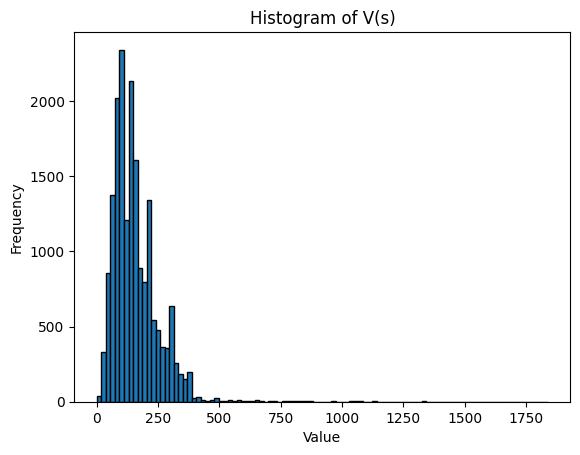

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
path = "/content/drive/MyDrive/bctp/PGRainbow/Distribution_Results/valuefunctiondist.txt.npy"
traj = np.load(path, allow_pickle=True)
plt.hist(traj, bins=100, edgecolor='black')
plt.title('Histogram of V(s)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Save model
def save(agent, optimizer, trajectories):
  save_path = f"/content/drive/MyDrive/code/PGRainbow/DemonAttack/{run_name}" + "_model.pth"
  print(f"Saving Model to {save_path}")
  torch.save({
          'model_state_dict': agent.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'value_function': trajectories,
          }, save_path)
save(agent, optimizer, trajectories)

In [ ]:
"""Q(s,a)"""
def get_qfunc_distribution(fixed_action):
  args = PPOArgs
  # TRY NOT TO MODIFY: seeding
  random.seed(args.seed)
  np.random.seed(args.seed)
  torch.manual_seed(args.seed)
  torch.backends.cudnn.deterministic = args.torch_deterministic

  device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
  env_name = "DemonAttack-v5"
  envs = envpool.make(
      env_name,
      env_type="gym",
      num_envs=args.num_envs,
      episodic_life=True,
      reward_clip=True,
      seed=args.seed,
  )
  envs.num_envs = args.num_envs
  envs.single_action_space = envs.action_space
  envs.single_observation_space = envs.observation_space
  envs = RecordEpisodeStatistics(envs)

  """Q(s_0, a)"""
  trajectories = []
  while len(trajectories) != 5000:
    obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
    rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
    dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
    values = torch.zeros((args.num_steps, args.num_envs)).to(device)
    avg_returns = deque(maxlen=20)
    # TRY NOT TO MODIFY: start the game
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)

    for step in range(0, 128):
      global_step += args.num_envs
      obs[step] = next_obs
      dones[step] = next_done
      logprob = None
      # ALGO LOGIC: action logic
      with torch.no_grad():
          if step != 0:
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
          else:
            action = fixed_action
      actions[step] = action
      #logprobs[step] = logprob

      # TRY NOT TO MODIFY: execute the game and log data.
      next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
      rewards[step] = torch.tensor(reward).to(device).view(-1)
      next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

      for idx, d in enumerate(next_done):
          if d and info["lives"][idx] == 0:
              #print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
              avg_returns.append(info["r"][idx])
              trajectories.append(info["r"][idx])
              tqdm.write(f"Array length: {len(trajectories)}")
      if len(trajectories) >= 5000:
        break
  return trajectories

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
action = torch.Tensor([2,2,2,2,2,2,2,2]).to(torch.int).to(device)
name = "action2"
trajectories = get_qfunc_distribution(action)
path = f"/content/drive/MyDrive/code/PGRainbow/{name}dist.txt"
np.save(path, np.array(trajectories))
print(f"Saved to {path}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create two 1D NumPy arrays (for demonstration)
v_path =  "/content/drive/MyDrive/code/PGRainbow/valuefunctiondist.txt.npy"
array1 = np.load(v_path, allow_pickle=True)
a_path = "/content/drive/MyDrive/code/PGRainbow/action0dist.txt.npy"
array2 = np.load(a_path, allow_pickle=True)

num_bins = 50

# Calculate the histograms
hist1, bins1 = np.histogram(array1, bins=num_bins)
hist2, bins2 = np.histogram(array2, bins=num_bins)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram 1
ax1.hist(array1, bins=num_bins, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_title('Distribution of Returns for Value Function')
ax1.set_xlabel('Return Values')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Calculate and plot the mean line for histogram 1
mean_value1 = np.mean(array1)
ax1.axvline(mean_value1, color='red', linestyle='dashed', linewidth=1.5)
ax1.text(mean_value1 + 0.05, max(hist1) * 0.9, f'Mean: {mean_value1:.2f}', color='red')

# Plot histogram 2
ax2.hist(array2, bins=num_bins, edgecolor='black', alpha=0.7, color='salmon')
ax2.set_title('Distribution of Returns for Action NO-OP')
ax2.set_xlabel('Return Values')
ax2.set_ylabel('Frequency')
ax2.grid(True)

# Calculate and plot the mean line for histogram 2
mean_value2 = np.mean(array2)
ax2.axvline(mean_value2, color='blue', linestyle='dashed', linewidth=1.5)
ax2.text(mean_value2 + 0.05, max(hist2) * 0.9, f'Mean: {mean_value2:.2f}', color='blue')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
action0 = torch.Tensor([0,0,0,0,0,0,0,0]).to(torch.int).to(device)
action1 = torch.Tensor([1,1,1,1,1,1,1,1]).to(torch.int).to(device)
action2 = torch.Tensor([2,2,2,2,2,2,2,2]).to(torch.int).to(device)
action3 = torch.Tensor([3,3,3,3,3,3,3,3]).to(torch.int).to(device)
action4 = torch.Tensor([4,4,4,4,4,4,4,4]).to(torch.int).to(device)
action5 = torch.Tensor([5,5,5,5,5,5,5,5]).to(torch.int).to(device)
items = [action0, action1, action2, action3, action4, action5]

for item in items:
  print(f"Action {item}")
  name = "action" + str(item[0].item())
  trajectories = get_qfunc_distribution(item)
  path = f"/content/drive/MyDrive/code/PGRainbow/{name}dist.txt"
  np.save(path, np.array(trajectories))
  print(f"Saved to {path}")

In [ ]:
state = next_obs[0].unsqueeze(0)
fixed_state = state.repeat(args.num_envs, 1, 1, 1)
print(f"fixed_state shape: {fixed_state.shape}")

In [ ]:
""" calculate V(s_0) and Q(s_0, a_i) and compare the distributions """

In [ ]:
from collections import Counter

def get_qs_distribution(actions):
  rewards = np.array([])
  for i in range(100):
    _, reward, _, _ = envs.step(actions.cpu().numpy())
    if rewards.size == 0:
      rewards = reward
    else:
      # If array1 is not empty, append array2 to it
      rewards = np.append(rewards, reward)

  counts = Counter(rewards)
  num_unique_values = len(counts)
  print("Number of unique values:", num_unique_values)
  print("Unique values and their counts:", counts)
  return counts
get_qs_distribution(actions)

In [ ]:
action0 = torch.Tensor([0,0,0,0,0,0,0,0]).to(torch.int).to(device)
action1 = torch.Tensor([1,1,1,1,1,1,1,1]).to(torch.int).to(device)
action2 = torch.Tensor([2,2,2,2,2,2,2,2]).to(torch.int).to(device)
action3 = torch.Tensor([3,3,3,3,3,3,3,3]).to(torch.int).to(device)
action4 = torch.Tensor([4,4,4,4,4,4,4,4]).to(torch.int).to(device)
action5 = torch.Tensor([5,5,5,5,5,5,5,5]).to(torch.int).to(device)
items = [action0, action1, action2, action3, action4, action5]
counters = {}
for item in items:
  name = "action" + str(item[0].item())
  counters[name] = get_qs_distribution(item)

## IQNPPO Train

#### No lag

In [ ]:
@dataclass
class IQNArgs:
    exp_name: str = "test8_run1"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "SpaceInvaders-v5"
    """the id of the environment"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    iqn_update_epochs: int = 1
    """the K epochs to update the iqn"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""
    iqn_start: int = 1000000 // 2
    iqn_per: bool = False
    iqn_N: int = 32
    double_q_learning: bool = False
    dueling_net: bool = False
    noisy_net: bool = False

    # to be filled in runtime
    batch_size: int = 128*8 # args.num_envs * args.num_steps
    """the batch size (computed in runtime)"""
    minibatch_size: int = 128//4 # args.batch_size // args.num_minibatches
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 1000000 // (128*8) # args.total_timesteps // args.batch_size
    """the number of iterations (computed in runtime)"""

In [ ]:
IQNArgs.env_id

In [ ]:
for i in range(0,5):
  args = IQNArgs
  args.env_id = f"SpaceInvaders-v{i}"
  print(f"env_id: {args.env_id}")

In [ ]:
args = IQNArgs
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}"
print(f"run_name: {run_name}")

writer = SummaryWriter(f"/content/drive/MyDrive/code/PGRainbow/SpaceInvaders/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = envpool.make(
    args.env_id,
    env_type="gym",
    num_envs=args.num_envs,
    episodic_life=True,
    reward_clip=True,
    seed=args.seed,
)
envs.num_envs = args.num_envs
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space
envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

iqn_configs = {
        'observation_space': envs.observation_space,
        'action_space': envs.action_space,
        'N': args.iqn_N,
        'N_dash': args.iqn_N,
        'double_q_learning': args.double_q_learning,
        'dueling_net': args.dueling_net,
        'noisy_net': args.noisy_net,
        'use_per': args.iqn_per
}

iqn_model = IQNAgent(**iqn_configs)
iqn_optimizer = iqn_model.optimizer

if args.iqn_per:
    iqn_replay_buffer = LazyPrioritizedMultiStepMemory(capacity=10**5, state_shape=envs.observation_space.shape,
                                                       device=device, gamma=0.99, multi_step=1, beta_steps=args.total_timesteps / 4)
else:
    iqn_replay_buffer = LazyMultiStepMemory(capacity=10**5, state_shape=envs.observation_space.shape, device=device,
                                            gamma=0.99, multi_step=1)



agent = AgentCriticTDDistillation(envs.action_space.n, iqn_configs['N']).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)
avg_returns = deque(maxlen=20)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)

loop_range = tqdm.tqdm(range(0, args.num_iterations + 1))
for iteration in loop_range:
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(next_obs, dtype=torch.float32).to(device))
            action, logprob, _, value = agent(torch.tensor(next_obs, dtype=torch.float32).to(device), q)
            #print(f"ALGO LOGIC: action logic action: {action.shape}")
            #print(f"ALGO LOGIC: action logic value: {value.shape}")
            values[step] = value.flatten()
            #print(f"ALGO LOGIC: action logic values shape: {values.shape}")
        actions[step] = action
        #print(f"ALGO LOGIC: action logic actions shape: {actions.shape}")
        logprobs[step] = logprob
        #print(f"ALGO LOGIC: action logic logprobs shape: {logprobs.shape}")

        # TRY NOT TO MODIFY: execute the game and log data.
        state = next_obs
        next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        ################## Fill IQN Replay Buffer ##################
        experience_batch = {
                        'obs': state,
                        'next_obs': next_obs,
                        'actions': action,
                        'rewards': reward,
                        'dones': next_done,
                        'infos': info
        }
        s, ns, ac, re, do, inf = experience_batch['obs'], experience_batch['next_obs'], experience_batch['actions'], experience_batch['rewards'], experience_batch['dones'], experience_batch['infos']
        for w in range(args.num_envs):
          o = s[w].cpu()
          # print(f"o type: {type(o)}")
          #print(f"o shape: {o.shape}")
          no = ns[w].cpu()
          #print(f"no shape: {no.shape}")
          a = ac[w].detach().cpu().numpy()
          #print(f"a shape: {a} and type: {type(a)}")
          r = re[w]
          #print(f"r shape: {r}")
          d = do[w].cpu()
          #print(f"d shape: {d}")
          i = inf
          iqn_replay_buffer.append(o, a, r, no, d)
        ########################################################################

        for idx, d in enumerate(next_done):
            if d and info["lives"][idx] == 0:
                print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
                avg_returns.append(info["r"][idx])
                writer.add_scalar("charts/avg_episodic_return", np.average(avg_returns), global_step)
                writer.add_scalar("charts/episodic_return", info["r"][idx], global_step)
                writer.add_scalar("charts/episodic_length", info["l"][idx], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        #print(f"next_obs shape: {next_obs.shape}")
        q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(next_obs, dtype=torch.float32).to(device))
        _, _, _, next_value = agent(torch.tensor(next_obs, dtype=torch.float32).to(device), q)
        next_value = next_value.reshape(1,-1)
        #print(f"gae next_value shape: {next_value.shape}")
        #print(f"rewards shape: {rewards.shape}")
        advantages = torch.zeros_like(rewards).to(device)
        #print(f"gae advantages shape: {advantages.shape}")
        #print(f"gae values shape: {values.shape}")
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            #print(f"delta shape: {delta.shape}")
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            #print(f"advantages shape: {advantages.shape}")
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    ################# IQN Train #################
    if len(iqn_replay_buffer) >= 32:
        cum_iqn_loss = 0
        for iqn_update_epoch in range(args.iqn_update_epochs):
          if args.iqn_per:
            (iqn_states, iqn_actions, iqn_rewards, iqn_next_states, iqn_dones), iqn_weights = iqn_replay_buffer.sample(32)
          else:
            iqn_states, iqn_actions, iqn_rewards, iqn_next_states, iqn_dones = iqn_replay_buffer.sample(32)
          iqn_loss, errors = iqn_model.train(iqn_states, iqn_actions, iqn_rewards, iqn_next_states, iqn_dones)
          if args.iqn_per:
              iqn_replay_buffer.update_priority(errors)
          cum_iqn_loss += iqn_loss
        writer.add_scalar("train/iqn_loss", cum_iqn_loss, global_step)
    if iteration % 250 == 0:
        print(f"Updating target iqn model at step: {iteration}")
        iqn_model.update_target()
    ###################################################

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(b_obs[mb_inds], dtype=torch.float32).to(device))
            #print(f"b_obs[mb_inds] shape: {b_obs[mb_inds].shape} q shape: {q.shape}")
            #print(f"b_actions.long()[mb_inds] shape: {b_actions.long()[mb_inds].shape}")
            #print(b_obs[mb_inds])
            _, newlogprob, entropy, newvalue = agent(torch.tensor(b_obs[mb_inds], dtype=torch.float32).to(device), q, action=b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

#### Value Function Distribution

In [ ]:
@dataclass
class DistIQNArgs:
    exp_name: str = "iqn_ppo_critic_cat_run1"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "DemonAttack-v5"
    """the id of the environment"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    iqn_update_epochs: int = 1
    """the K epochs to update the iqn"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""
    iqn_start: int = 1000000 // 2
    iqn_per: bool = False
    iqn_N: int = 32
    double_q_learning: bool = False
    dueling_net: bool = False
    noisy_net: bool = False

    # to be filled in runtime
    batch_size: int = 128*8 # args.num_envs * args.num_steps
    """the batch size (computed in runtime)"""
    minibatch_size: int = 128//4 # args.batch_size // args.num_minibatches
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 1000000 // (128*8) # args.total_timesteps // args.batch_size
    """the number of iterations (computed in runtime)"""

In [ ]:
"""V(s_0) PG-RAINBOW"""
args = DistIQNArgs
# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

env_name = "DemonAttack-v5"
envs = envpool.make(
    env_name,
    env_type="gym",
    num_envs=args.num_envs,
    episodic_life=True,
    reward_clip=True,
    seed=args.seed,
)
envs.num_envs = args.num_envs
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space
envs = RecordEpisodeStatistics(envs)

iqn_configs = {
        'observation_space': envs.observation_space,
        'action_space': envs.action_space,
        'N': args.iqn_N,
        'N_dash': args.iqn_N,
        'double_q_learning': args.double_q_learning,
        'dueling_net': args.dueling_net,
        'noisy_net': args.noisy_net,
        'use_per': args.iqn_per
}

iqn_model = IQNAgent(**iqn_configs)
iqn_optimizer = iqn_model.optimizer

if args.iqn_per:
    iqn_replay_buffer = LazyPrioritizedMultiStepMemory(capacity=10**5, state_shape=envs.observation_space.shape,
                                                       device=device, gamma=0.99, multi_step=1, beta_steps=args.total_timesteps / 4)
else:
    iqn_replay_buffer = LazyMultiStepMemory(capacity=10**5, state_shape=envs.observation_space.shape, device=device,
                                            gamma=0.99, multi_step=1)



agent = AgentCriticDistillation(envs.action_space.n, iqn_configs['N']).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)
avg_returns = deque(maxlen=20)
# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

trajectories = []
while len(trajectories) != 5000:
  for step in range(0, args.num_steps):
    global_step += args.num_envs
    obs[step] = next_obs
    dones[step] = next_done

    # ALGO LOGIC: action logic
    with torch.no_grad():
        q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(next_obs, dtype=torch.float32).to(device))
        action, logprob, _, value = agent(torch.tensor(next_obs, dtype=torch.float32).to(device), q)
    actions[step] = action
    logprobs[step] = logprob

    # TRY NOT TO MODIFY: execute the game and log data.
    state = next_obs
    next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
    rewards[step] = torch.tensor(reward).to(device).view(-1)
    next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

    ################## Fill IQN Replay Buffer ##################
    experience_batch = {
                    'obs': state,
                    'next_obs': next_obs,
                    'actions': action,
                    'rewards': reward,
                    'dones': next_done,
                    'infos': info
    }
    s, ns, ac, re, do, inf = experience_batch['obs'], experience_batch['next_obs'], experience_batch['actions'], experience_batch['rewards'], experience_batch['dones'], experience_batch['infos']
    for w in range(args.num_envs):
      o = s[w].cpu()
      # print(f"o type: {type(o)}")
      #print(f"o shape: {o.shape}")
      no = ns[w].cpu()
      #print(f"no shape: {no.shape}")
      a = ac[w].detach().cpu().numpy()
      #print(f"a shape: {a} and type: {type(a)}")
      r = re[w]
      #print(f"r shape: {r}")
      d = do[w].cpu()
      #print(f"d shape: {d}")
      i = inf
      iqn_replay_buffer.append(o, a, r, no, d)
    ########################################################################
    for idx, d in enumerate(next_done):
        if d and info["lives"][idx] == 0:
            print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
            avg_returns.append(info["r"][idx])
            trajectories.append(info["r"][idx])
            tqdm.write(f"Array length: {len(trajectories)}")
    if len(trajectories) >= 5000:
      break

#### Lagging Trainer (Bad Performance)

In [ ]:
@dataclass
class LagIQNArgs:
    exp_name: str = "iqn_ppo_lagcritic_run2"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "AirRaid-v5"
    """the id of the environment"""
    total_timesteps: int = 1000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""
    iqn_start: int = 1000000 // 2
    iqn_per: bool = False
    iqn_N: int = 32
    double_q_learning: bool = False
    dueling_net: bool = False
    noisy_net: bool = False

    # to be filled in runtime
    batch_size: int = 128*8 # args.num_envs * args.num_steps
    """the batch size (computed in runtime)"""
    minibatch_size: int = 128//4 # args.batch_size // args.num_minibatches
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 1000000 // (128*8) # args.total_timesteps // args.batch_size
    """the number of iterations (computed in runtime)"""

In [ ]:
#################################### Lagging Distillation ####################################

args = LagIQNArgs
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}"

writer = SummaryWriter(f"/content/drive/MyDrive/code/PGRainbow/AirRaid/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = envpool.make(
    args.env_id,
    env_type="gym",
    num_envs=args.num_envs,
    episodic_life=True,
    reward_clip=True,
    seed=args.seed,
)
envs.num_envs = args.num_envs
envs.single_action_space = envs.action_space
envs.single_observation_space = envs.observation_space
envs = RecordEpisodeStatistics(envs)
assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

iqn_configs = {
        'observation_space': envs.observation_space,
        'action_space': envs.action_space,
        'N': args.iqn_N,
        'N_dash': args.iqn_N,
        'double_q_learning': args.double_q_learning,
        'dueling_net': args.dueling_net,
        'noisy_net': args.noisy_net,
        'use_per': args.iqn_per
}
iqn_model = IQNAgent(**iqn_configs)
iqn_optimizer = iqn_model.optimizer
start_iqn = False

iqn_replay_buffer = LazyMultiStepMemory(capacity=10**5, state_shape=envs.observation_space.shape, device=device, gamma=0.99, multi_step=1)

agent = LagAgentCriticDistillation(envs.action_space.n, iqn_configs['N']).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)
avg_returns = deque(maxlen=20)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)

loop_range = tqdm.tqdm(range(0, args.num_iterations + 1))
for iteration in loop_range:
    # Start IQN Distillation
    if iteration > (args.num_iterations // 2):
      start_iqn = True
      print(f"IQN Distillation Started at step {global_step}")
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(next_obs, dtype=torch.float32).to(device))
            action, logprob, _, value = agent(torch.tensor(next_obs, dtype=torch.float32).to(device), q, start_iqn=start_iqn)
            #print(f"ALGO LOGIC: action logic action: {action.shape}")
            #print(f"ALGO LOGIC: action logic value: {value.shape}")
            values[step] = value.flatten()
            #print(f"ALGO LOGIC: action logic values shape: {values.shape}")
        actions[step] = action
        #print(f"ALGO LOGIC: action logic actions shape: {actions.shape}")
        logprobs[step] = logprob
        #print(f"ALGO LOGIC: action logic logprobs shape: {logprobs.shape}")

        # TRY NOT TO MODIFY: execute the game and log data.
        state = next_obs
        next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        ################## Fill IQN Replay Buffer ##################
        experience_batch = {
                        'obs': state,
                        'next_obs': next_obs,
                        'actions': action,
                        'rewards': reward,
                        'dones': next_done,
                        'infos': info
        }
        s, ns, ac, re, do, inf = experience_batch['obs'], experience_batch['next_obs'], experience_batch['actions'], experience_batch['rewards'], experience_batch['dones'], experience_batch['infos']
        for w in range(args.num_envs):
          o = s[w].cpu()
          # print(f"o type: {type(o)}")
          #print(f"o shape: {o.shape}")
          no = ns[w].cpu()
          #print(f"no shape: {no.shape}")
          a = ac[w].detach().cpu().numpy()
          #print(f"a shape: {a} and type: {type(a)}")
          r = re[w]
          #print(f"r shape: {r}")
          d = do[w].cpu()
          #print(f"d shape: {d}")
          i = inf
          iqn_replay_buffer.append(o, a, r, no, d)
        ########################################################################

        for idx, d in enumerate(next_done):
            if d and info["lives"][idx] == 0:
                print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
                avg_returns.append(info["r"][idx])
                writer.add_scalar("charts/avg_episodic_return", np.average(avg_returns), global_step)
                writer.add_scalar("charts/episodic_return", info["r"][idx], global_step)
                writer.add_scalar("charts/episodic_length", info["l"][idx], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        #print(f"next_obs shape: {next_obs.shape}")
        q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(next_obs, dtype=torch.float32).to(device))
        _, _, _, next_value = agent(torch.tensor(next_obs, dtype=torch.float32).to(device), q, start_iqn=start_iqn)
        next_value = next_value.reshape(1,-1)
        #print(f"gae next_value shape: {next_value.shape}")
        #print(f"rewards shape: {rewards.shape}")
        advantages = torch.zeros_like(rewards).to(device)
        #print(f"gae advantages shape: {advantages.shape}")
        #print(f"gae values shape: {values.shape}")
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            #print(f"delta shape: {delta.shape}")
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            #print(f"advantages shape: {advantages.shape}")
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    ################# IQN Train #################
    if len(iqn_replay_buffer) >= 32:
        cum_iqn_loss = 0
        iqn_states, iqn_actions, iqn_rewards, iqn_next_states, iqn_dones = iqn_replay_buffer.sample(32)
        iqn_loss, _ = iqn_model.train(iqn_states, iqn_actions, iqn_rewards, iqn_next_states, iqn_dones)
        cum_iqn_loss += iqn_loss
        writer.add_scalar("train/iqn_loss", cum_iqn_loss, global_step)
    if iteration % 250 == 0:
        print(f"Updating target iqn model at step: {iteration}")
        iqn_model.update_target()
    ###################################################

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            q, quantiles = iqn_model.online_net.calculate_q(torch.tensor(b_obs[mb_inds], dtype=torch.float32).to(device))
            #print(f"b_obs[mb_inds] shape: {b_obs[mb_inds].shape} q shape: {q.shape}")
            #print(f"b_actions.long()[mb_inds] shape: {b_actions.long()[mb_inds].shape}")
            _, newlogprob, entropy, newvalue = agent(torch.tensor(b_obs[mb_inds], dtype=torch.float32).to(device), q, start_iqn=start_iqn, action=b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

In [ ]:
save_path = f"/content/drive/MyDrive/code/PGRainbow/SpaceInvaders/cleanrl/runs/{run_name}" + "iqnppo_model.pth"
print(f"Saving Model to {save_path}")
torch.save({
        'model_state_dict': agent.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'iqn_model_state-dict': iqn_model.state_dict(),
        'iqn_optimizer_state_dict': iqn_optimizer.state_dict(),
        }, save_path)

## Results

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=/content/drive/MyDrive/code/PGRainbow/AirRaid